In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import bisect

sys.path.insert(0, '../../..')

from cde.density_estimator import MixtureDensityNetwork
from cde.data_collector import MatlabDataset, MatlabDatasetH5
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
""" Open MATLAB file """

#matds = MatlabDataset('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
#matds = MatlabDataset('../../data/dataset_normal_400k.mat')
matds = MatlabDataset('../../data/fulldataset_gamma_400k.mat') 


 Dataset loaded from .mat file. Rows: 399997   Columns: 4 


In [3]:
""" Take conditioned samples and fit density model """

N_tr = matds.n_records

#data = matds.get_data_servicerate_cond([1,1,1])

#data = matds.get_data_firstrows_cond(N_tr)
#train_data = data[0:N_tr,[0,1,3,5]]

train_data = matds.get_data(N_tr)
#train_data = data[0:N_tr,:]

Y = train_data[:,0]
X = train_data[:,1:]

model = MixtureDensityNetwork("GMM_3hop_expar_H", ndim_x=3, n_centers=20, ndim_y=1,n_training_epochs=1000,hidden_sizes=(32, 32))
model.fit(X, Y)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2761s | loss: 450910.500
mean log-loss train: 1.1273


In [3]:
""" Take samples and fit density model """

train_data = matds.get_data(50000)
Y = train_data[:,0]
X = train_data[:,1:]

model = MixtureDensityNetwork("GMM_3hop_expar", ndim_x=6, n_centers=20, ndim_y=1,n_training_epochs=1000,hidden_sizes=(32, 32))
model.fit(X, Y)

1000/1000 [100%] ██████████████████████████████ Elapsed: 363s | loss: -2862.367
mean log-loss train: -0.0572


In [4]:
""" Save the trained model and the training data into file """

with open('saves/New_3hop_gamma_400k_3dim.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

np.save('saves/New_ds_gamma_400k_3dim.npy', train_data)

In [3]:
""" Load the trained model and training dataset from file """

dummy = MixtureDensityNetwork("GMM_3hop_expar", ndim_x=2, ndim_y=1)
dummy._setup_inference_and_initialize()

with open('saves/New_3hop_expar_400k_3dim_H.pkl', 'rb') as input:
    dummy = pickle.load(input)

model = dummy

train_data = np.load('saves/New_ds_expar_400k_3dim_H.npy')

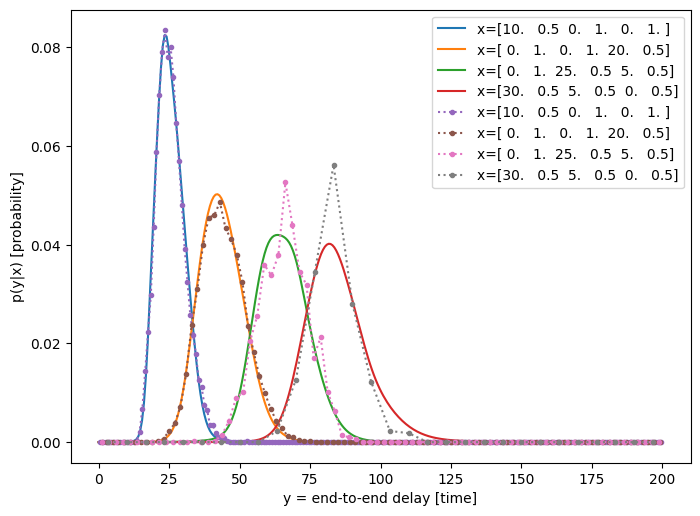

In [4]:
plt.ioff()

""" plot the fitted distribution """
x_cond_plot = np.array([[10, 0.5, 0, 1, 0, 1],[0, 1, 0, 1, 20, 0.5],[0, 1, 25, 0.5, 5, 0.5],[30, 0.5, 5, 0.5, 0, 0.5]])
y_lim = (0, 200)
fig = model.plot2d(x_cond_plot, ylim=y_lim, resolution=300, show=False, prefix='predicted',fsize=[8,6],fdpi=100,fxlabel="y = end-to-end delay [time]",fylabel="p(y|x) [probability]")

""" plot the conditional histogram """
data = matds.get_data(matds.n_records)
resolution_array = (200,100,80,30)
fig = plot_conditional_hist(data,x_cond_plot, ylim=y_lim, resolution=resolution_array, show=True, holdonfig=fig, prefix='measured',fsize=[8,6],fdpi=100)

plt.show()


Calculating percentiles [96%]

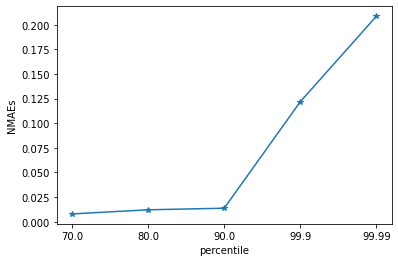

In [5]:

''' Calculate Normalized Mean Absolute Error (NMAE) '''


dataset = matds.get_data(matds.n_records)
#dataset = matds.get_data(int(matds.n_records*0.1))
testdataset = matds.get_data(5)
testdataset = testdataset[:,1:]
perc_arr = np.array([ 70,80,90,99.9,99.99 ])
NMAEs = []

for j in range(len(perc_arr)):
    p_perc = perc_arr[j]
    res = []
    for i in range(len(testdataset)):
        prog = (j*len(testdataset)+i)/(len(testdataset)*len(perc_arr))*100
        print('\rCalculating percentiles [%d%%]'%prog, end="")
        xc = np.array([testdataset[i,:]])
        measured_perc,num_samples,avg = measure_percentile(dataset=dataset,x_cond=xc,p_perc=p_perc)
        if num_samples > 1000:
            #predicted_perc = model.new_quantile_cdf_m(x_cond=xc,alpha=p_perc/100, eps=1e-3, init_bound=200)
            predicted_perc = model.find_perc(x_cond=xc,alpha=(100-p_perc)/100, eps=1e-3, init_bound=200)
            res.append(abs(measured_perc-predicted_perc)/measured_perc)
        else:
            continue

    nmae = np.mean(res)
    #print("percentile: ", p_perc ,", number of samples: ", len(res), " MAE:", nmae)
    NMAEs.append(nmae)

fig, ax = plt.subplots()
ax.plot(range(len(NMAEs)),NMAEs, marker='*') #substitute actual plotting here
ax.set_xticks(range(len(NMAEs)))
ax.set_xticklabels(perc_arr)
plt.xlabel('percentile')
plt.ylabel('NMAEs')

plt.show()

In [40]:
''' Select 5 network states from training data with more than 5k samples '''

#dataset = matds.get_data(matds.n_records)
np.max(train_data[:,0])

testnetstates = []
while len(testnetstates) < 5:
    #cond_sample = matds.get_data(10)[0,1:]
    idx = np.random.randint(len(train_data), size=1)
    cond_samples = train_data[idx,:]
    cond_sample = cond_samples[0,1:]
    measured_perc,num_samples,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_sample]),p_perc=50)
    if (num_samples > 200) and ( list(cond_sample) not in testnetstates ):
        if(cond_sample[0]>=0 and cond_sample[1]>=0 and cond_sample[2]>=0):
            print(cond_sample)
            testnetstates.append(list(cond_sample))

[30.  5.  0.]
[ 0. 30.  0.]
[30.  0.  0.]
[30.  0.  1.]
[30.  6.  0.]


 Dataset H5 loaded from .mat file. Rows: 54180860   Columns: 4 


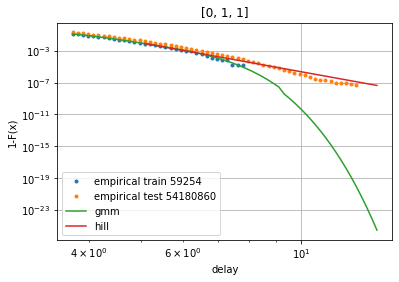

In [21]:
""" Open analysis MATLAB file - [0,1,1] state """

#matds = MatlabDataset('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') dataset_conditional_[0_1_0]_27M.mat
cond_matds = MatlabDatasetH5('../../data/dataset_conditional_[0_1_1]_54M.mat')

cond_state = [0,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1 ), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.01)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 


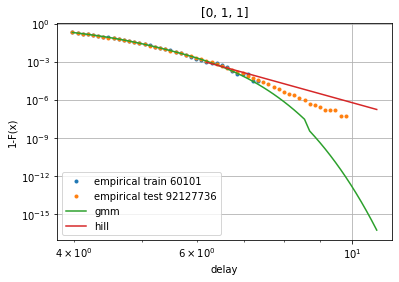

In [22]:
""" Open analysis MATLAB file - [0,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_1]_92M.mat')

cond_state = [0,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.001)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 


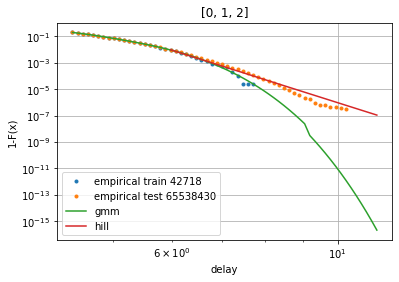

In [19]:
""" Open analysis MATLAB file - [0,1,2] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat')

cond_state = [0,1,2]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.01)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 


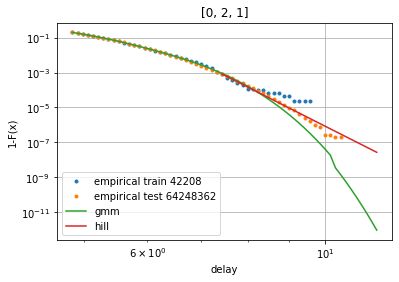

In [21]:
""" Open analysis MATLAB file - [0,1,2] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_2_1]_92M.mat')

cond_state = [0,2,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.001)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 


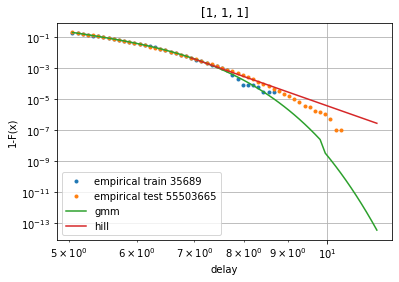

In [25]:
""" Open analysis MATLAB file - [1,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[1_1_1]_92M.mat')

cond_state = [1,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.005)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

In [ ]:
""" Open analysis MATLAB file - [0,1,2] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat')

cond_state = [0,1,2]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

#dsh = matds.get_data(300000)
alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.01)
xhill = []
tailhill=[]
for i in range(len(x)):
    if x[i]>xk:
        xhill.append(x[i])
        tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

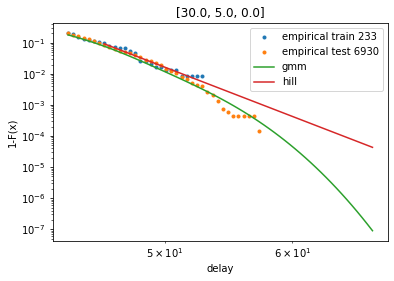

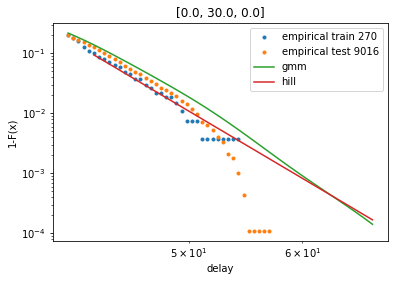

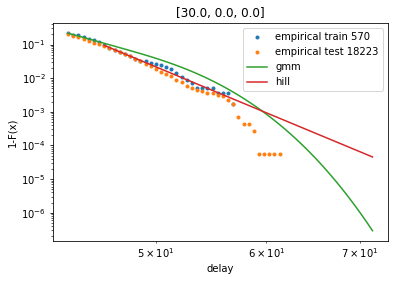

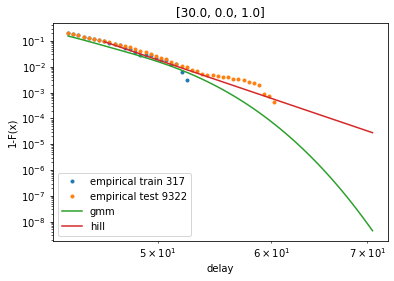

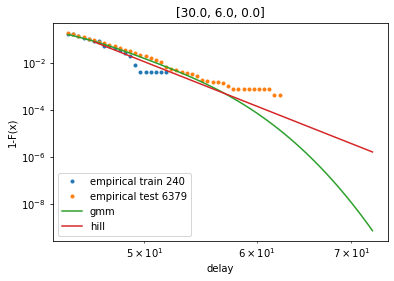

In [41]:
''' Plot loglog tail probabilities '''

for j in range(len(testnetstates)):
    cond_state = testnetstates[j]
    tmp = matds.get_data(matds.n_records)
    test_data = tmp[:,[0,1,3,5]]

    tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
    measured_p8,num_samples_test,avg = measure_percentile(dataset=test_data,x_cond=np.array([cond_state]),p_perc=80)
    measured_1,num_samples_test,avg = measure_percentile(dataset=test_data,x_cond=np.array([cond_state]),p_perc=100)
    x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+10 ), num=60)
    #x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
    #print(x)
    tail=[]
    for i in range(len(x)):
        tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

    ftail=[]
    for i in range(len(x)):
        ftail.append(measure_tail(dataset=test_data,x_cond=np.array([cond_state]),y=x[i]))

    #xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
    tailh=[]
    for i in range(len(x)):
        tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

    #dsh = matds.get_data(300000)
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=0.1)
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

    fig, ax = plt.subplots()
    ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
    ax.loglog(xhill,tailhill, label="hill") #substitute actual plotting here
    plt.xlabel('delay')
    plt.ylabel('1-F(x)')
    plt.title(str(cond_state))
    plt.legend()
    plt.show()

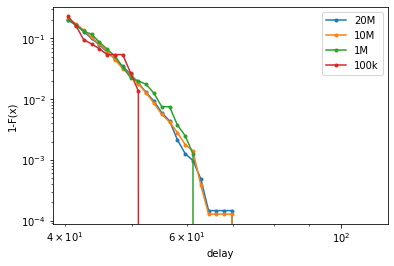

In [25]:
ds0 = matds.get_data(matds.n_records)
ds1 = matds.get_data(10000000)
ds2 = matds.get_data(1000000)
ds3 = matds.get_data(100000)

''' Plot loglog tail probabilities '''

cond_state = testnetstates[0]
measured_p8,num_samples,avg = measure_percentile(dataset=ds0,x_cond=np.array([cond_state]),p_perc=80)
measured_1,num_samples,avg = measure_percentile(dataset=ds0,x_cond=np.array([cond_state]),p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)
tail0=[]
for i in range(len(x)):
    tail0.append(measure_tail(dataset=ds0,x_cond=np.array([cond_state]),y=x[i]))

tail1=[]
for i in range(len(x)):
    tail1.append(measure_tail(dataset=ds1,x_cond=np.array([cond_state]),y=x[i]))

tail2=[]
for i in range(len(x)):
    tail2.append(measure_tail(dataset=ds2,x_cond=np.array([cond_state]),y=x[i]))

tail3=[]
for i in range(len(x)):
    tail3.append(measure_tail(dataset=ds3,x_cond=np.array([cond_state]),y=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail0, marker='.', label="20M") #substitute actual plotting here
ax.loglog(x,tail1, marker='.', label="10M") #substitute actual plotting here
ax.loglog(x,tail2, marker='.', label="1M") #substitute actual plotting here
ax.loglog(x,tail3, marker='.', label="100k") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.legend()
plt.show()


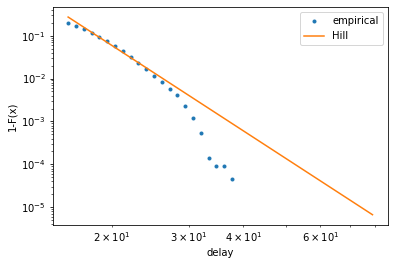

In [5]:

ds0 = matds.get_data(matds.n_records)
cond_state = testnetstates[0]
measured_p8,num_samples,avg = measure_percentile(dataset=ds0,x_cond=np.array([cond_state]),p_perc=80)
measured_1,num_samples,avg = measure_percentile(dataset=ds0,x_cond=np.array([cond_state]),p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)
tail0=[]
for i in range(len(x)):
    tail0.append(measure_tail(dataset=ds0,x_cond=np.array([cond_state]),y=x[i]))


dsh = matds.get_data(10000000)
alpha,xk,k,n = init_tail_index_hill(dataset=dsh,x_cond=np.array([cond_state]),beta=0.1)
tailhill=[]
for i in range(len(x)):
    tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))

fig, ax = plt.subplots()
ax.loglog(x,tail0, marker='.', label="empirical", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailhill, label="Hill") #substitute actual plotting here
plt.xlabel('delay')
plt.ylabel('1-F(x)')
plt.legend()
plt.show()


In [16]:
ds3 = matds.get_data(100000)
np.save('ds3.npy', ds3)

In [18]:
salam = np.load('ds3.npy')
print(salam[1])

[53.34944065 25.          0.5         0.          1.5         0.
  1.5       ]
